# HopperBulletEnv with Twin Delayed DDPG (TD3)

### Paper: https://arxiv.org/abs/1802.09477


### 1. Start the Environment and Agent 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import pybullet_envs
import pybullet_envs.bullet as bul

#from torch.autograd import Variable
import torch.nn.functional as F

import gym
#import argparse
import os

import time
from TwinDelayed_U import Actor, Critic, ReplayBuffer, TD3
from collections import deque


current_dir=/home/rafaels/ml-agents/lib/python3.7/site-packages/pybullet_envs/bullet
device:  cpu


In [2]:
start_timestep=1e4

std_noise=0.03

env = gym.make('HopperBulletEnv-v0')

# Set seeds
seed = 12345
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

state = env.reset()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])
threshold = env.spec.reward_threshold

print('start_dim: ', state_dim, ', action_dim: ', action_dim)
print('n max_action: ', max_action, ', threshold: ', threshold)

agent = TD3(state_dim, action_dim, max_action)


start_dim:  15 , action_dim:  3
n max_action:  1.0 , threshold:  2500.0


### 2. Traning the agent

In [3]:
# save(agent = agent, filename='checkpnt, directory = 'dir_chkpoint')     
def save(agent, filename, directory):
    torch.save(agent.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
    torch.save(agent.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))
    torch.save(agent.actor_target.state_dict(), '%s/%s_actor_t.pth' % (directory, filename))
    torch.save(agent.critic_target.state_dict(), '%s/%s_critic_t.pth' % (directory, filename))   

In [4]:
# Twin Delayed Deep Deterministic (TD3) policy gradient algorithm
def twin_ddd_train(n_episodes=15000, save_every=10, print_env=40):

    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []    

    time_start = time.time()                    # Init start time
    replay_buf = ReplayBuffer()                 # Init ReplayBuffer
    
    timestep_after_last_save = 0
    total_timesteps = 0
    
    low = env.action_space.low
    high = env.action_space.high
    
    print('Low in action space: ', low, ', High: ', high, ', Action_dim: ', action_dim)
            
    for i_episode in range(1, n_episodes+1):
        
        timestep = 0
        total_reward = 0
        
        # Reset environment
        state = env.reset()
        done = False
        
        while True:
            
            # Select action randomly or according to policy
            if total_timesteps < start_timestep:
                action = env.action_space.sample()
            else:
                action = agent.select_action(np.array(state))
                if std_noise != 0: 
                    shift_action = np.random.normal(0, std_noise, size=action_dim)
                    action = (action + shift_action).clip(low, high)
            
            # Perform action
            new_state, reward, done, _ = env.step(action) 
            done_bool = 0 if timestep + 1 == env._max_episode_steps else float(done)
            total_reward += reward                          # full episode reward

            # Store every timestep in replay buffer
            replay_buf.add((state, new_state, action, reward, done_bool))
            state = new_state

            timestep += 1     
            total_timesteps += 1
            timestep_after_last_save += 1

            if done:                                       # done ?
                break                                      # save score

        scores_deque.append(total_reward)
        scores_array.append(total_reward)

        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        
        max_score = np.max(scores_deque)
        
        # train_by_episode(time_start, i_episode) 
        s = (int)(time.time() - time_start)
        if i_episode % print_env == 0 or (len(scores_deque) == 100 and avg_score > threshold):
            print('Ep. {}, Timestep {},  Ep.Timesteps {}, Score: {:.2f}, Avg.Score: {:.2f}, Max.Score: {:.2f},  Time: {:02}:{:02}:{:02} '\
                .format(i_episode, total_timesteps, timestep, \
                        total_reward, avg_score, max_score, s//3600, s%3600//60, s%60))     

        agent.train(replay_buf, timestep)

        # Save episode if more than save_every=5000 timesteps
        if timestep_after_last_save >= save_every and i_episode > 0:

            timestep_after_last_save %= save_every            
            save(agent, 'chpnt_1', 'dir_chk_003')  
        
        if len(scores_deque) == 100 and avg_score >= threshold:
            print('Environment solved with Average Score: ',  avg_score )
            break 

    return scores_array, avg_scores_array

scores, avg_scores = twin_ddd_train()

Low in action space:  [-1. -1. -1.] , High:  [1. 1. 1.] , Action_dim:  3
Ep. 40, Timestep 488,  Ep.Timesteps 9, Score: 18.06, Avg.Score: 19.97, Max.Score: 26.26,  Time: 00:00:07 
Ep. 80, Timestep 963,  Ep.Timesteps 14, Score: 22.76, Avg.Score: 20.10, Max.Score: 33.08,  Time: 00:00:17 
Ep. 120, Timestep 1442,  Ep.Timesteps 11, Score: 20.15, Avg.Score: 20.36, Max.Score: 33.08,  Time: 00:00:28 
Ep. 160, Timestep 1940,  Ep.Timesteps 7, Score: 20.11, Avg.Score: 20.18, Max.Score: 33.08,  Time: 00:00:40 
Ep. 200, Timestep 2436,  Ep.Timesteps 14, Score: 21.62, Avg.Score: 20.37, Max.Score: 30.01,  Time: 00:00:52 
Ep. 240, Timestep 2997,  Ep.Timesteps 12, Score: 19.13, Avg.Score: 20.60, Max.Score: 38.31,  Time: 00:01:05 
Ep. 280, Timestep 3488,  Ep.Timesteps 7, Score: 16.72, Avg.Score: 20.58, Max.Score: 43.57,  Time: 00:01:17 
Ep. 320, Timestep 4001,  Ep.Timesteps 11, Score: 15.33, Avg.Score: 20.27, Max.Score: 43.57,  Time: 00:01:29 
Ep. 360, Timestep 4469,  Ep.Timesteps 8, Score: 19.94, Avg.Sco

Ep. 2880, Timestep 1537112,  Ep.Timesteps 1000, Score: 2645.05, Avg.Score: 2318.04, Max.Score: 2680.23,  Time: 20:26:58 
Ep. 2920, Timestep 1574451,  Ep.Timesteps 1000, Score: 2480.05, Avg.Score: 2351.63, Max.Score: 2699.69,  Time: 21:01:22 
Ep. 2960, Timestep 1607917,  Ep.Timesteps 1000, Score: 2564.41, Avg.Score: 2273.12, Max.Score: 2699.69,  Time: 21:32:13 
Ep. 3000, Timestep 1642912,  Ep.Timesteps 157, Score: 378.34, Avg.Score: 2199.56, Max.Score: 2724.86,  Time: 22:05:13 
Ep. 3040, Timestep 1677333,  Ep.Timesteps 1000, Score: 2545.76, Avg.Score: 2116.48, Max.Score: 2724.86,  Time: 22:36:08 
Ep. 3080, Timestep 1715076,  Ep.Timesteps 1000, Score: 2542.09, Avg.Score: 2165.23, Max.Score: 2693.50,  Time: 23:10:47 
Ep. 3120, Timestep 1753646,  Ep.Timesteps 1000, Score: 2520.82, Avg.Score: 2333.67, Max.Score: 2657.68,  Time: 23:46:14 
Ep. 3160, Timestep 1786406,  Ep.Timesteps 1000, Score: 2566.96, Avg.Score: 2261.97, Max.Score: 2661.73,  Time: 24:16:20 
Ep. 3200, Timestep 1826406,  Ep.Ti

In [5]:
save(agent, 'chpnt_2', 'dir_chk_003')  

length of scores:  3240 , len of avg_scores:  3240


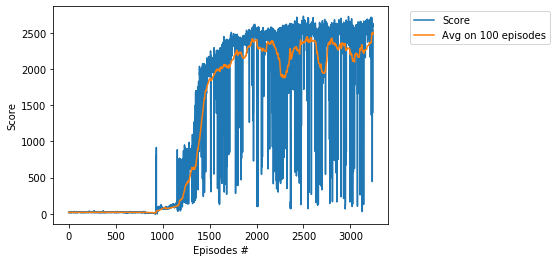

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [8]:
from collections import deque
import os

def play(env, agent, n_episodes):
    state = env.reset()
    
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_episodes+1):
        state = env.reset()        
        score = 0
        
        time_start = time.time()
        
        while True:
            action = agent.select_action(np.array(state))
            env.render()
            time.sleep(0.01)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            score += reward
            if done:
                break 

        s = (int)(time.time() - time_start)
        
        scores_deque.append(score)
        scores.append(score)
        
        print('Episode {}\tAverage Score: {:.2f},\tScore: {:.2f} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque), score, s//3600, s%3600//60, s%60))  

play(env=env, agent=agent, n_episodes=10)


Episode 1	Average Score: 2493.66,	Score: 2493.66 	Time: 00:00:13
Episode 2	Average Score: 2511.80,	Score: 2529.95 	Time: 00:00:13
Episode 3	Average Score: 2517.11,	Score: 2527.71 	Time: 00:00:13
Episode 4	Average Score: 1924.03,	Score: 144.82 	Time: 00:00:01
Episode 5	Average Score: 2040.35,	Score: 2505.62 	Time: 00:00:13
Episode 6	Average Score: 2124.66,	Score: 2546.23 	Time: 00:00:13
Episode 7	Average Score: 2179.24,	Score: 2506.69 	Time: 00:00:13
Episode 8	Average Score: 2219.78,	Score: 2503.57 	Time: 00:00:13
Episode 9	Average Score: 2254.13,	Score: 2528.94 	Time: 00:00:13
Episode 10	Average Score: 2282.75,	Score: 2540.31 	Time: 00:00:13


In [9]:
env.close()